In [1]:
import argparse
import numpy as np

# Main C3 objects
from c3.libraries import constants
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.optimizers.optimalcontrol import OptimalControl

#%matplotlib widget

from four_level_transmons.utilities import *
from four_level_transmons.plotting import *
from four_level_transmons.custom_envelopes import *
from four_level_transmons.DataOutput import DataOutput

2021-11-09 15:14:47.174912: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 15:14:47.174950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("output", help="Output directory")
args = parser.parse_args()
output_dir = args.output
#output_dir = "../output_0"

In [7]:
def printSignal(exper: Experiment, qubit: chip.Qubit,
                gate: gates.Instruction, output: DataOutput):
    # generate signal
    signal = generateSignal(exper, gate, qubit)
    ts = signal["ts"].numpy()
    values = signal["values"].numpy()

    # plot and save
    peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
    print("peaks: ", np.sort(peakFrequencies))
    output.save([ts, values], "signal")
    plotSignalAndSpectrum(ts, values, filename=output.createFileName("signal", "png"))


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")

    plotComplexMatrix(U, xlabels=labels, ylabels=labels, filename=output.createFileName("propagator"))
    plotComplexMatrixAbsOrPhase(U, xlabels=labels, ylabels=labels, phase=True, filename=output.createFileName("propagator_phase"))
    plotComplexMatrixAbsOrPhase(U, xlabels=labels, ylabels=labels, phase=False, filename=output.createFileName("propagator_abs"))

In [8]:
# Initialise the qubits and drive lines
qubit_levels = 5
qubit_frequency = 5e9
anharmonicity = -300e6
t1 = 25e-6
t2star = 35e-6
qubit_temp = 50e-3
level_labels = ["$|0,0\\rangle$", "$|0,1\\rangle$", "$|1,0\\rangle$", "$|1,1\\rangle$", "leakage"]
output = DataOutput(output_dir, file_suffix='before')

qubit = createQubits([qubit_levels], [qubit_frequency], [anharmonicity], [t1],
                      [t2star], qubit_temp)[0]
drive = createDrives([qubit])[0]

In [9]:
# Create the model
model = Mdl([qubit], [drive])
model.set_lindbladian(False)
model.set_dressed(True)

In [10]:
# Create the generator
sim_res = 100e9
awg_res = 2e9
v2hz = 1e9
generator = createGenerator([drive], useDrag=True)

enabling DRAG2


In [11]:
# Envelopes and carriers
t_final = 30e-9
sideband = 50e6
carrier_freqs = [4.7e9]

gaussian_envelope = createPWCDoubleGaussianPulse(
    t_final=t_final,
    sigma=t_final / 15,
    sigma2=t_final / 30,
    relative_amp=2,
    num_pieces=30
)
nodrive_envelope = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s")
    },
    shape=envelopes.no_drive
)

qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(carrier_freqs, sideband)

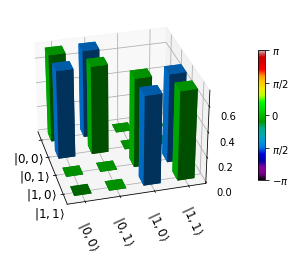

In [24]:
# Gate instructions
ideal_gate = qt_utils.np_kron_n([constants.Id, constants.x90p])
plotComplexMatrix(ideal_gate, xlabels=level_labels[:4], ylabels=level_labels[:4],
                  filename=output.createFileName("ideal_gate", "png"))
rx90p_q1 = createSingleQubitGate("rx90p", [drive], carriers, 0, t_final,
                                 gaussian_envelope, nodrive_envelope, sideband,
                                 ideal=ideal_gate)

peaks:  [3.20106702e+09 4.20140047e+09 4.53484495e+09 5.00166722e+09]


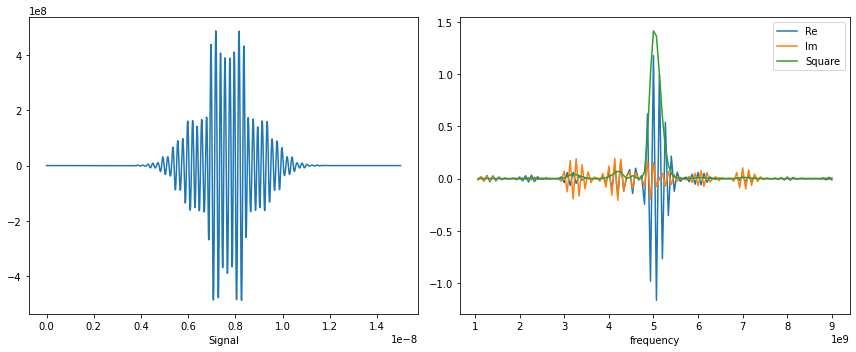

/home/user/c3/four_level_transmons/plotting.py:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


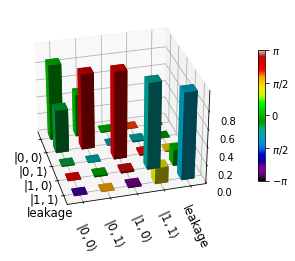

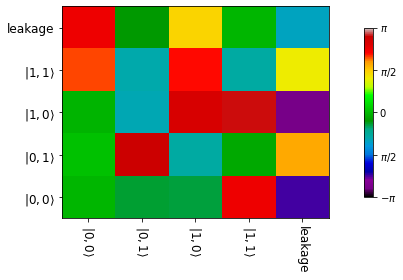

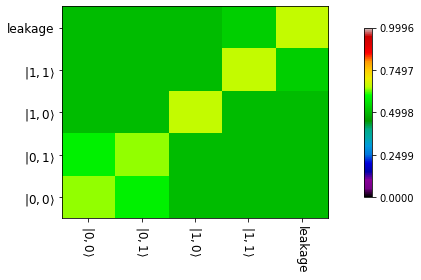

In [25]:
# Set up the experiment
parameter_map = PMap(instructions=[rx90p_q1], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([rx90p_q1.get_key()])

printSignal(exp, qubit, rx90p_q1, output)

unitaries = exp.compute_propagators()
printPropagator(exp, rx90p_q1, level_labels, output)

In [14]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [rx90p_q1.get_key()]

exp.compute_propagators()
printTimeEvolution(exp, init_state, rx90p_q1, level_labels, output)
#plotSplittedPopulation(exp, init_state, sequence)

In [17]:
# Specify the parameters to be optimised and initialise the optimiser
parameter_map.set_opt_map([
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "amp")],
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "freq_offset")],
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "xy_angle")],
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "delta")],
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "t_final")],
    [(rx90p_q1.get_key(), "d1", gaussian_envelope.name, "inphase")],
    [(rx90p_q1.get_key(), "d1", "carrier", "freq")],
    [(rx90p_q1.get_key(), "d1", "carrier", "framechange")],
])
parameter_map.print_parameters()

opt = OptimalControl(
    dir_path=output.getDirectory(),
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=[qubit.name],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 400},
    run_name="rx90_q1",
    fid_func_kwargs={
        "active_levels": 4
    }
)
exp.set_opt_gates([rx90p_q1.get_key()])
opt.set_exp(exp)
opt.set_callback(lambda fidelity: print(fidelity))

rx90p[0]-d1-pwc-amp                   : 500.000 mV 
rx90p[0]-d1-pwc-freq_offset           : -53.000 MHz 2pi 
rx90p[0]-d1-pwc-xy_angle              : 0.000 rad 
rx90p[0]-d1-pwc-delta                 : -1.000  
rx90p[0]-d1-pwc-t_final               : 15.000 ns 
rx90p[0]-d1-pwc-inphase               : 6.1e-13  2.58e-11  8.37e-10  2.07e-08  3.94e-07  5.71e-06  6.35e-05  0.00054  0.00351  0.0175  0.0666  0.191  0.363  0.14  -0.782  -0.782  0.14  0.363  0.191  0.0666  0.0175  0.00351  0.00054  6.35e-05  5.71e-06  3.94e-07  2.07e-08  8.37e-10  2.58e-11  6.1e-13  
rx90p[0]-d1-carrier-freq              : 4.750 GHz 2pi 
rx90p[0]-d1-carrier-framechange       : 0.000 rad 



In [18]:
# Run the optimisation
opt.optimize_controls()
opt.current_best_goal

C3:STATUS:Saving as: /home/user/c3/four_level_transmons/output/rx90_q1/2021_11_09_T_15_17_26/open_loop.log
0.9991533981069824


/home/user/c3/c3/optimizers/optimizer.py:290: Warning: rx90p[0]-d1-pwc-t_final has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


0.9456780651020934
0.8625613394376622
0.7401975138414663
0.9916040829193556
0.9518762033927524
0.9394809525789812
0.7401975138414663
0.7650805453787248
0.8769809379896047
0.89056992258123
0.992413796933901
0.9305769419852401
0.7218873735529676
0.8405807274020503
0.7678849705827291
0.999982869895301
0.7085722498224942
0.7037702510754515
0.7037694048000205
0.7037694039540798


0.7037694039540798

rx90p[0]-d1-pwc-amp                   : 500.086 mV 
rx90p[0]-d1-pwc-freq_offset           : -53.024 MHz 2pi 
rx90p[0]-d1-pwc-xy_angle              : 12.675 mrad 
rx90p[0]-d1-pwc-delta                 : -1.141  
rx90p[0]-d1-pwc-t_final               : 15.000 ns 
rx90p[0]-d1-pwc-inphase               : -0.00079  -0.00346  -0.00208  -0.000279  -0.002  -0.00294  -0.00195  -0.00241  0.000492  0.0168  0.0656  0.188  0.36  0.138  -0.785  -0.785  0.138  0.361  0.188  0.0657  0.0168  0.000571  -0.0023  -0.00183  -0.00282  -0.00191  -0.000146  -0.00191  -0.00251  0.000457  
rx90p[0]-d1-carrier-freq              : 1.359 GHz 2pi 
rx90p[0]-d1-carrier-framechange       : -2.506 rad 

peaks:  [8.66955652e+08 1.13371124e+09 1.66722241e+09 2.66755585e+09]


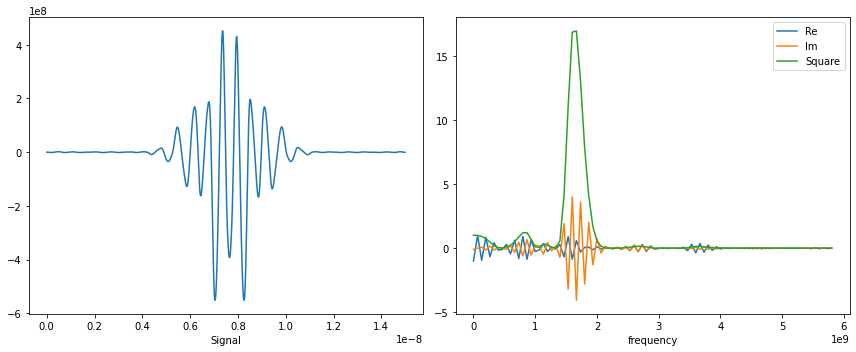

/home/user/c3/four_level_transmons/plotting.py:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


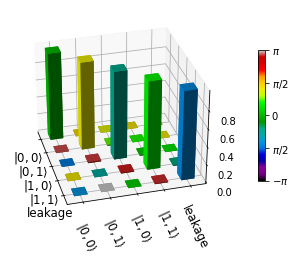

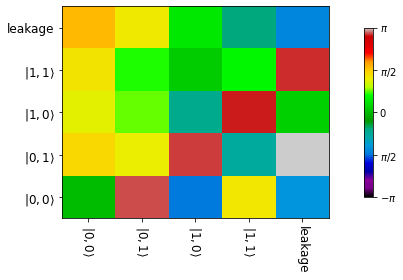

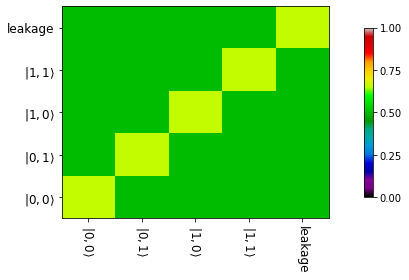

In [19]:
# Print and plot results
parameter_map.print_parameters()

output = DataOutput(output_dir, file_suffix='after')
printSignal(exp, qubit, rx90p_q1, output)
printPropagator(exp, rx90p_q1, level_labels, output)
printTimeEvolution(exp, init_state, rx90p_q1, level_labels, output)